<a href="https://colab.research.google.com/github/karanpk02/DATA-SCIENCE-PROJECT-1/blob/main/DEMAND_FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Item Demand Forecasting**
****
****
##**Problem Statement**
******
Demand forecasts are fundamental to plan and deliver products
and services. Accurate forecasting of demand can help the
manufacturers to maintain appropriate stock which results in
reduction in loss due to product not being sold and also
reduces the opportunity cost (i.e. higher demand but less
availability => opportunity lost). Despite such relevance,
manufacturers have difficulty choosing which forecast model is
the best for their use case. In this project, historical sales data
corresponding to multiple(25) items sold in 10 stores are
provided and participants are expected to come up with a best
model to predict the future demand for products which results in
maximum profit for the manufacturer. **Predict the demand for
the next 3 months at the item level (i.e. all the stores
combined)**.

###**Data**

The historical sales raw data is available [HERE](https://raw.githubusercontent.com/karanpk02/DATA-SCIENCE-PROJECT-1/main/train%202.csv). The item, store and
sales details are provided at the daily level for a period
spanning 4 years.

###**Minimum Requirements**
The end objective of the participant is to produce a model that
gives the best **prediction** to the manufacturer. Such a model
must include the seasonality of the items sold.

![link text](https://miro.medium.com/max/1400/1*RG1ybhW-wvw8SAdNrK7VVg.png)

####**Import libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score # import all the functions reqd for cross validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

####**Read Datas**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/karanpk02/DATA-SCIENCE-PROJECT-1/main/train%202.csv")

In [ ]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


####**Analysing the given data**

In [ ]:
df.shape

(913000, 4)

In [ ]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

Clearly we can see the date column is not in the right format. We want to convert it into the date times.

In [ ]:
df['date'] = pd.to_datetime(df['date'],format = "%Y-%m-%d")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [ ]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Here, we have no null values.

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(913000, 4)

Which clearly shows that it has no duplicates.

In [ ]:
df.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

We have 10 unique stores and 50 unique items are there.
More clearly,

In [ ]:
print(df['store'].unique())
print(df['item'].unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


To find out minimum and maximum dates in the data given. Reference [From stackoverflow](https://stackoverflow.com/questions/23178129/getting-min-and-max-dates-from-a-pandas-dataframe)

Use agg to determine the minimum and maximum value in one line :

In [ ]:
df['date'].agg(['min', 'max'])

min   2013-01-01
max   2017-12-31
Name: date, dtype: datetime64[ns]

By date diiference calculator it gives that : 

Difference between Jan 1, 2013 and Dec 31, 2017
is 1826 Calendar Days. In our dataset contain 1826 unique days. That means it contain every data between those days. No missing datas.

In [ ]:
df.shape

(913000, 4)

In [ ]:
df[df['date']=='2013-01-01']

,date,store,item,sales
0,2013-01-01,1,1,13
1826,2013-01-01,2,1,12
3652,2013-01-01,3,1,19
5478,2013-01-01,4,1,10
7304,2013-01-01,5,1,11
...,...,...,...,...
903870,2013-01-01,6,50,20
905696,2013-01-01,7,50,21
907522,2013-01-01,8,50,45
909348,2013-01-01,9,50,36


So, we can see 500x1826 = 913000. That is, which equal to the total number of rows. Which ensure that it must contain all the data for all items with respect to all stores in everyday.

###**BASIC EDA -1**

####**Now we are going to find out more factors affecting on sales. It can be seen that in the normal human thinking, year, month, week and days are related to sales. Let us verify here whether all this features mentioned are correct.**

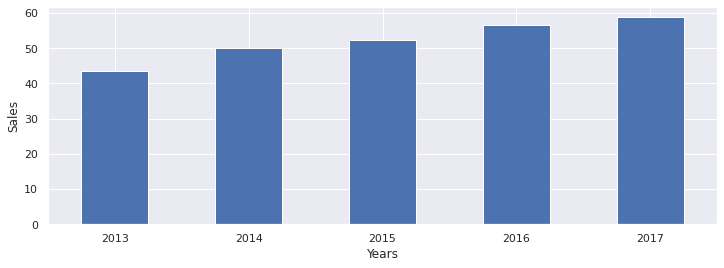

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["date"].dt.year)["sales"].mean().plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Years");  # custom x label using Matplotlib
plt.ylabel("Sales");
#df.groupby(df["date"].dt.year)["sales"].mean()

We can find out year and sales has some relations.

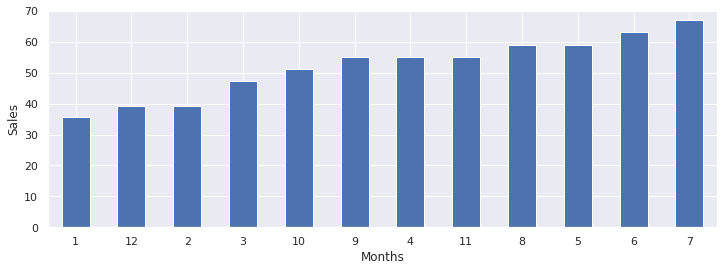

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["date"].dt.month)["sales"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Months");  # custom x label using Matplotlib
plt.ylabel("Sales");
# df.groupby(df["date"].dt.month)["sales"].mean()

Also sales are correlated between months.

####**Similary we have some days of the week like sunday, monday, tuesday, wednesday, thursday, friday and saturday sales relations. Now we are going to identify such relations also.**

In [ ]:
df['week_days'] = df['date'].dt.day_name()

In [ ]:
df = df[['date', 'week_days', 'store', 'item', 'sales']]

In [ ]:
df

,date,week_days,store,item,sales
0,2013-01-01,Tuesday,1,1,13
1,2013-01-02,Wednesday,1,1,11
2,2013-01-03,Thursday,1,1,14
3,2013-01-04,Friday,1,1,13
4,2013-01-05,Saturday,1,1,10
...,...,...,...,...,...
912995,2017-12-27,Wednesday,10,50,63
912996,2017-12-28,Thursday,10,50,59
912997,2017-12-29,Friday,10,50,74
912998,2017-12-30,Saturday,10,50,62


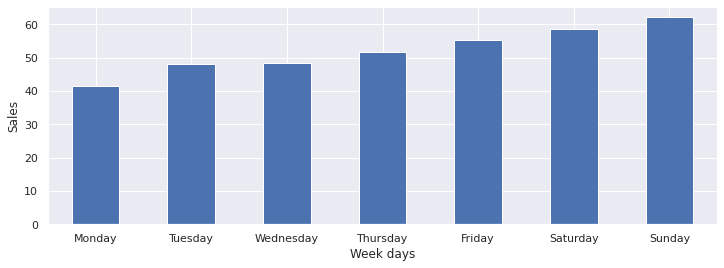

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["week_days"])["sales"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Week days");  # custom x label using Matplotlib
plt.ylabel("Sales");

Days has also relations between sales.

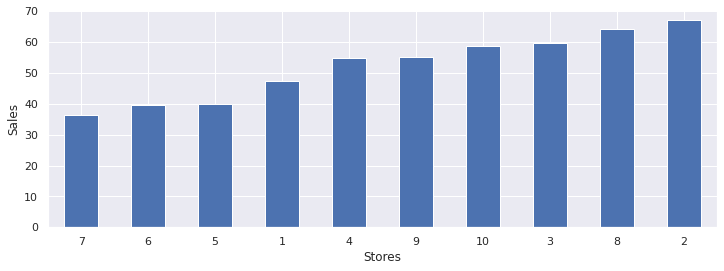

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby("store")["sales"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Stores");  # custom x label using Matplotlib
plt.ylabel("Sales");

Mean sales over the stores also has some relations.

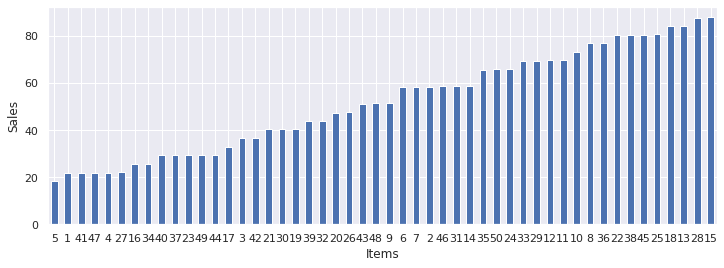

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby("item")["sales"].mean().sort_values(ascending=True).plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Items");  # custom x label using Matplotlib
plt.ylabel("Sales");

Mean sales over the items has also some relations.

####**Now we are going to check sales on weeks(7 day sales)**

In [ ]:
k = df.resample('7D', on='date').sales.sum()
k

date
2013-01-01    102836
2013-01-08    103879
2013-01-15    102913
2013-01-22    103437
2013-01-29    110177
               ...  
2017-11-28    180241
2017-12-05    154637
2017-12-12    155423
2017-12-19    155253
2017-12-26    137944
Freq: 7D, Name: sales, Length: 261, dtype: int64

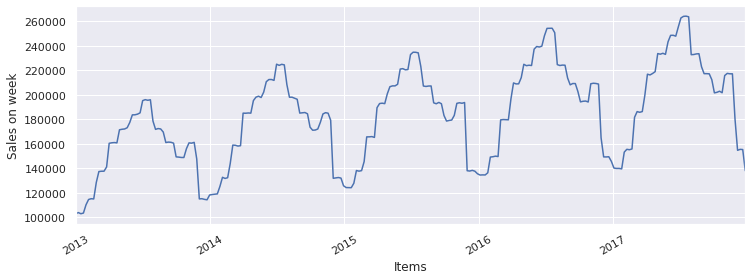

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
k.plot(kind='line', rot=30, ax=axs)
plt.xlabel("Items");  # custom x label using Matplotlib
plt.ylabel("Sales on week");

Week sales also show some good pattern relations.

####**Sales on 3 month periods**

In [ ]:
# data re-sampled based on each month
k = df.resample('3M', on='date').sales.sum()
k

date
2013-01-31     454904
2013-04-30    1759073
2013-07-31    2414761
2013-10-31    2113255
2014-01-31    1725237
2014-04-30    2022332
2014-07-31    2778729
2014-10-31    2429603
2015-01-31    1931344
2015-04-30    2106735
2015-07-31    2901436
2015-10-31    2540986
2016-01-31    2037656
2016-04-30    2307788
2016-07-31    3150112
2016-10-31    2741962
2017-01-31    2172165
2017-04-30    2382898
2017-07-31    3256703
2017-10-31    2852826
2018-01-31    1624007
Freq: 3M, Name: sales, dtype: int64

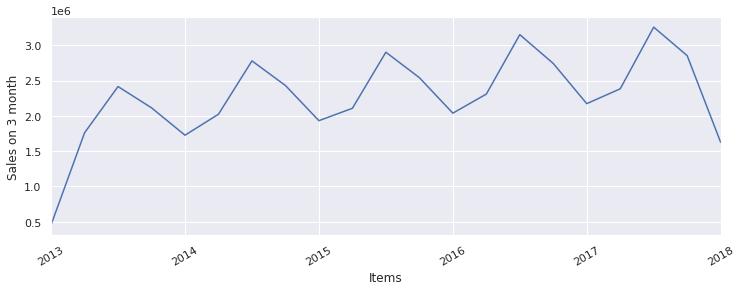

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
k.plot(kind='line', rot=30, ax=axs)
plt.xlabel("Items");  # custom x label using Matplotlib
plt.ylabel("Sales on 3 month");

3 month sales also follow some good pattern relations.

####**CONCLUSIONS FROM BASIC EDA-1**
******
1. Store and item has some relation with sales.
2. Year has importance.
3. Mont has importance.
4. Week days also has some importance.
5. Week(7-day) sale has good pattern v/s time.
6. Similarly, for 3 month sales has good pattern.

*******
*******
####**EXTRA FEATURES ARE GOING TO ADD**
******
1. WEEK DAY(already added)
2. month
3. year
4. week sale(rolling sum)
5. month sale(rolling sum)
6. 3 month sale(rolling sum)

In [ ]:
# df1 = df.groupby([pd.Grouper(key='date', freq='D'), 'week_days', 'store', 'item']).agg(total_sale=('sales','sum'))
# k = df.groupby(by=['date', 'item'])["sales"].sum().to_frame()
# # df2 = pd.DataFrame(k)
# k

In [ ]:
df[df['item']==1]

,date,week_days,store,item,sales
0,2013-01-01,Tuesday,1,1,13
1,2013-01-02,Wednesday,1,1,11
2,2013-01-03,Thursday,1,1,14
3,2013-01-04,Friday,1,1,13
4,2013-01-05,Saturday,1,1,10
...,...,...,...,...,...
18255,2017-12-27,Wednesday,10,1,19
18256,2017-12-28,Thursday,10,1,12
18257,2017-12-29,Friday,10,1,23
18258,2017-12-30,Saturday,10,1,26


####**ADD YEAR AND MONTH COLUMNS**

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
df = df[['date', 'week_days', 'year', 'month', 'store', 'item', 'sales']]
df

,date,week_days,year,month,store,item,sales
0,2013-01-01,Tuesday,2013,1,1,1,13
1,2013-01-02,Wednesday,2013,1,1,1,11
2,2013-01-03,Thursday,2013,1,1,1,14
3,2013-01-04,Friday,2013,1,1,1,13
4,2013-01-05,Saturday,2013,1,1,1,10
...,...,...,...,...,...,...,...
912995,2017-12-27,Wednesday,2017,12,10,50,63
912996,2017-12-28,Thursday,2017,12,10,50,59
912997,2017-12-29,Friday,2017,12,10,50,74
912998,2017-12-30,Saturday,2017,12,10,50,62


In [ ]:
Train1 = df.copy()
Train1.drop(['date'], axis=1)
Train1
# Train1.to_csv("Train1.csv")

,date,week_days,year,month,store,item,sales
0,2013-01-01,Tuesday,2013,1,1,1,13
1,2013-01-02,Wednesday,2013,1,1,1,11
2,2013-01-03,Thursday,2013,1,1,1,14
3,2013-01-04,Friday,2013,1,1,1,13
4,2013-01-05,Saturday,2013,1,1,1,10
...,...,...,...,...,...,...,...
912995,2017-12-27,Wednesday,2017,12,10,50,63
912996,2017-12-28,Thursday,2017,12,10,50,59
912997,2017-12-29,Friday,2017,12,10,50,74
912998,2017-12-30,Saturday,2017,12,10,50,62


####**ADD ROLLING SUM FOR 7 DAY**

In [ ]:
df1 = df.copy()

In [ ]:
df1["rolling_sales_weeks"] = df1['sales'].rolling(window= 7, min_periods=1).sum().astype(int)

In [ ]:
df1.head(10)

,date,week_days,year,month,store,item,sales,rolling_sales_weeks
0,2013-01-01,Tuesday,2013,1,1,1,13,13
1,2013-01-02,Wednesday,2013,1,1,1,11,24
2,2013-01-03,Thursday,2013,1,1,1,14,38
3,2013-01-04,Friday,2013,1,1,1,13,51
4,2013-01-05,Saturday,2013,1,1,1,10,61
5,2013-01-06,Sunday,2013,1,1,1,12,73
6,2013-01-07,Monday,2013,1,1,1,10,83
7,2013-01-08,Tuesday,2013,1,1,1,9,79
8,2013-01-09,Wednesday,2013,1,1,1,12,80
9,2013-01-10,Thursday,2013,1,1,1,9,75


####**ADD ROLLING SUM FOR ONE MONTH**

In [ ]:
df1["rolling_sales_months"] = df1['sales'].rolling(window= 30, min_periods=1).sum().astype(int)

In [ ]:
df1

,date,week_days,year,month,store,item,sales,rolling_sales_weeks,rolling_sales_months
0,2013-01-01,Tuesday,2013,1,1,1,13,13,13
1,2013-01-02,Wednesday,2013,1,1,1,11,24,24
2,2013-01-03,Thursday,2013,1,1,1,14,38,38
3,2013-01-04,Friday,2013,1,1,1,13,51,51
4,2013-01-05,Saturday,2013,1,1,1,10,61,61
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,Wednesday,2017,12,10,50,63,439,1927
912996,2017-12-28,Thursday,2017,12,10,50,59,435,1918
912997,2017-12-29,Friday,2017,12,10,50,74,434,1916
912998,2017-12-30,Saturday,2017,12,10,50,62,426,1905


####**ADD ROLLING SUM FOR THREE MONTH**

In [ ]:
df1["rolling_sales_three_months"] = df1['sales'].rolling(window= 90, min_periods=1).sum().astype(int)

In [ ]:
df1 = df1[['date', 'week_days', 'year', 'month', 'store', 'item', 'rolling_sales_weeks', 'rolling_sales_months', 'rolling_sales_three_months', 'sales']]

In [ ]:
df1

,date,week_days,year,month,store,item,rolling_sales_weeks,rolling_sales_months,rolling_sales_three_months,sales
0,2013-01-01,Tuesday,2013,1,1,1,13,13,13,13
1,2013-01-02,Wednesday,2013,1,1,1,24,24,24,11
2,2013-01-03,Thursday,2013,1,1,1,38,38,38,14
3,2013-01-04,Friday,2013,1,1,1,51,51,51,13
4,2013-01-05,Saturday,2013,1,1,1,61,61,61,10
...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,Wednesday,2017,12,10,50,439,1927,6984,63
912996,2017-12-28,Thursday,2017,12,10,50,435,1918,6953,59
912997,2017-12-29,Friday,2017,12,10,50,434,1916,6924,74
912998,2017-12-30,Saturday,2017,12,10,50,426,1905,6887,62


####**Create a column based on the difference consecutive week days sales**
(This factor was find out after one primary analysis with diagram of the predicted and the actual sales by plotly)

In [ ]:
# df1['week_difference'] = df1.groupby('date')['sales'].shift(7,freq='D')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date                        913000 non-null  datetime64[ns]
 1   week_days                   913000 non-null  object        
 2   year                        913000 non-null  int64         
 3   month                       913000 non-null  int64         
 4   store                       913000 non-null  int64         
 5   item                        913000 non-null  int64         
 6   rolling_sales_weeks         913000 non-null  int64         
 7   rolling_sales_months        913000 non-null  int64         
 8   rolling_sales_three_months  913000 non-null  int64         
 9   sales                       913000 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 76.6+ MB


####**Redefine df1 as df as copy**

In [ ]:
df = df1.copy()

####**Plots for all rolling sums v/s date**
*****
*****

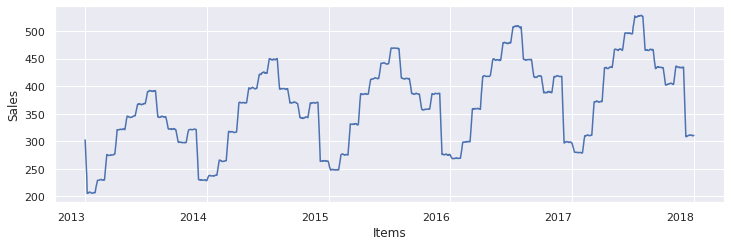

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby("date")["rolling_sales_weeks"].mean().sort_values(ascending=True).plot(kind='line', rot=0, ax=axs)
plt.xlabel("Items");  # custom x label using Matplotlib
plt.ylabel("Sales");

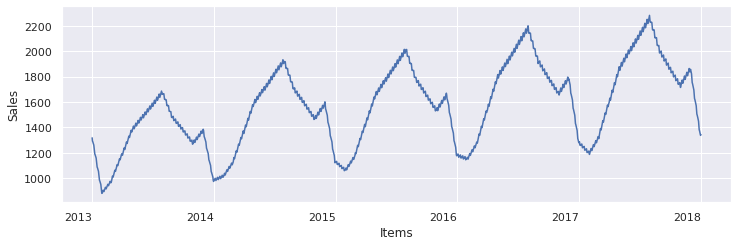

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby("date")["rolling_sales_months"].mean().sort_values(ascending=True).plot(kind='line', rot=0, ax=axs)
plt.xlabel("Items");  # custom x label using Matplotlib
plt.ylabel("Sales");

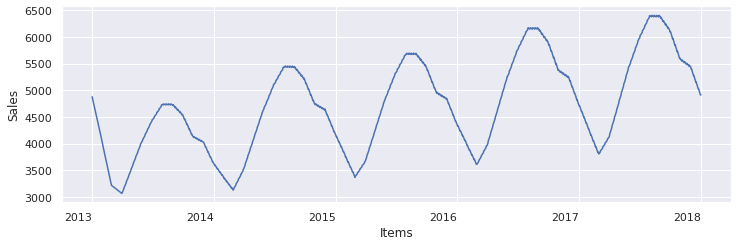

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby("date")["rolling_sales_three_months"].mean().sort_values(ascending=True).plot(kind='line', rot=0, ax=axs)
plt.xlabel("Items");  # custom x label using Matplotlib
plt.ylabel("Sales");

In [ ]:
# df.set_index(df['date'])

####**CHECK THE PRESENCE OF OUTLIERS**

In [ ]:
df3 = df.copy()
df3 = df3.drop(['date'], axis=1)

In [ ]:
def outlierpresence(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  whisker_width = 1.5
  lower_whisker = Q1 -(whisker_width*IQR)
  upper_whisker = Q3 + (whisker_width*IQR)
  df2 = pd.DataFrame((df < lower_whisker) | (df > upper_whisker ))
  for i in df2.keys():
    flag = True
    if True in df2[i].tolist():
      flag = False
    if flag:
      print('Outliers are', '\033[1m'+ ' not present in the data of' +'\033[0m', '\033[1m' + i + '\033[0m')
    else:
      print('Outliers are', '\033[1m'+ 'present' +'\033[0m', 'in the data of','\033[1m' + i + '\033[0m')
outlierpresence(df3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


Outliers are  not present in the data of item
Outliers are  not present in the data of month
Outliers are present in the data of rolling_sales_months
Outliers are present in the data of rolling_sales_three_months
Outliers are present in the data of rolling_sales_weeks
Outliers are present in the data of sales
Outliers are  not present in the data of store
Outliers are  not present in the data of week_days
Outliers are  not present in the data of year


####**TOTAL NUMBER OF OUTLIER VALUES OVER THE DATASET**

In [ ]:
def outlierpresence(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  whisker_width = 1.5
  lower_whisker = Q1 -(whisker_width*IQR)
  upper_whisker = Q3 + (whisker_width*IQR)
  df2 = pd.DataFrame((df < lower_whisker) | (df > upper_whisker ))
  for i in df2.keys():
    if df2[i].tolist().count(True) !=0:
      print('\033[1m' + i + '\033[0m')    
      print('-------------------------')
      print("Total number of Outlers is",df2[i].tolist().count(True))
      print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
outlierpresence(df3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


rolling_sales_months
-------------------------
Total number of Outlers is 6577
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
rolling_sales_three_months
-------------------------
Total number of Outlers is 5663
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
rolling_sales_weeks
-------------------------
Total number of Outlers is 7004
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sales
-------------------------
Total number of Outlers is 11967
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


####**Whisker plot for each outlier datas**
*****

*  rolling_sales_weeks
* rolling_sales_months
* rolling_sales_three_months

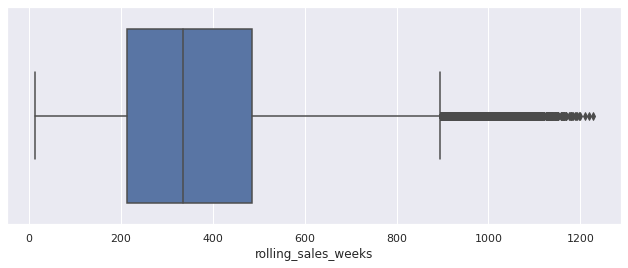

In [ ]:
sns.boxplot(x=df["rolling_sales_weeks"])

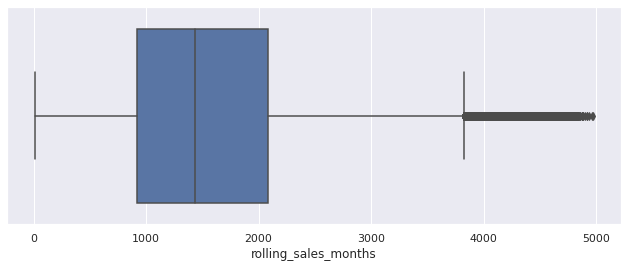

In [ ]:
sns.boxplot(x=df["rolling_sales_months"])

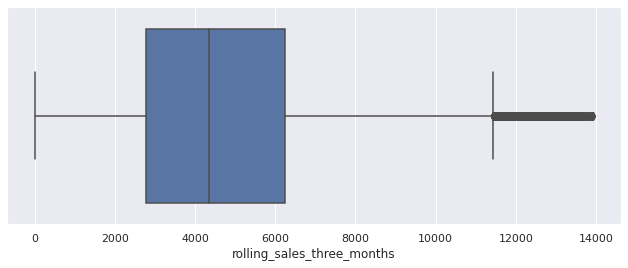

In [ ]:
sns.boxplot(x=df["rolling_sales_three_months"])

###**Basic EDA- 2**

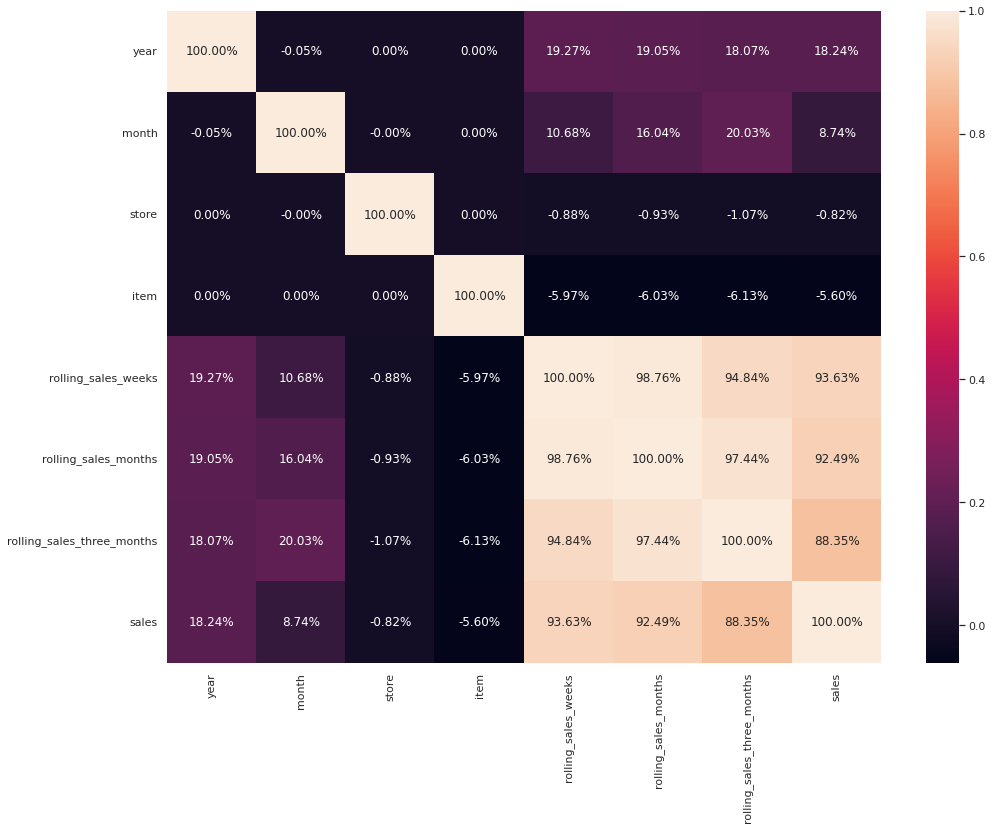

In [ ]:
plt.figure(figsize = (16, 12))
sns.heatmap(df.corr(), annot = True, fmt = '.2%')

Here we can see the sales has more correlation with **rolling_sales_weeks**, **rolling_sales_months** and **rolling_sales_three_months** and a little correlation with **year**.

Now we can do it detaily.

**Week days v/s Sales**

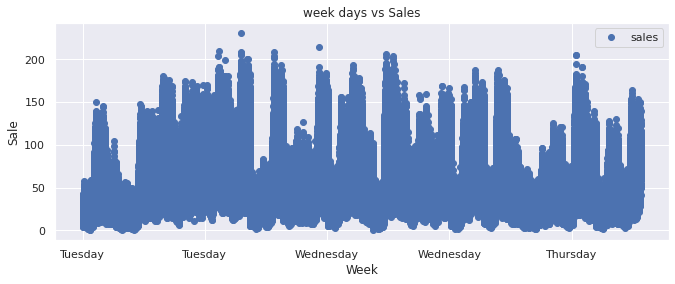

In [ ]:
df.plot(x='week_days', y='sales', style='o')
plt.title('week days vs Sales')
plt.xlabel('Week')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['week_days', 'sales']].corr()

,sales
sales,1.0


**Year v/s Sales**

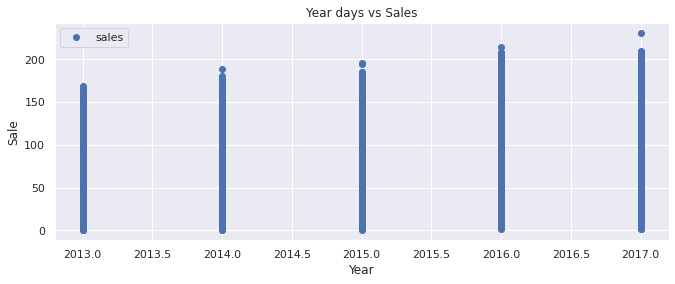

In [ ]:
df.plot(x='year', y='sales', style='o')
plt.title('Year days vs Sales')
plt.xlabel('Year')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['year', 'sales']].corr()

,year,sales
year,1.00000,0.18236
sales,0.18236,1.00000


**Month v/s Sales**

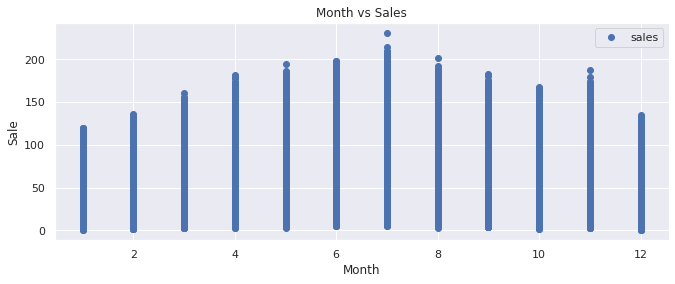

In [ ]:
df.plot(x='month', y='sales', style='o')
plt.title('Month vs Sales')
plt.xlabel('Month')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['month', 'sales']].corr()

,month,sales
month,1.000000,0.087414
sales,0.087414,1.000000


**Store v/s Sales**

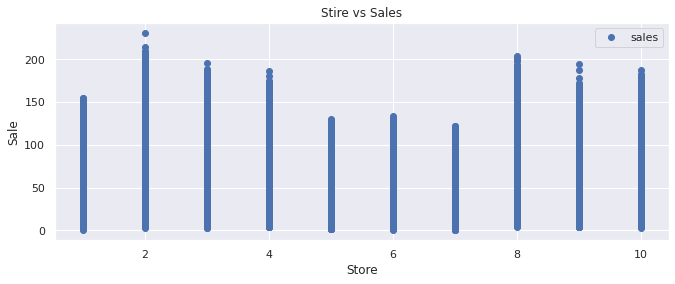

In [ ]:
df.plot(x='store', y='sales', style='o')
plt.title('Stire vs Sales')
plt.xlabel('Store')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['store', 'sales']].corr()

,store,sales
store,1.00000,-0.00817
sales,-0.00817,1.00000


**Items v/s Sales**

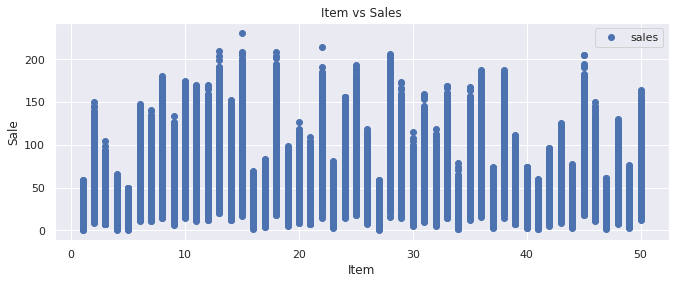

In [ ]:
df.plot(x='item', y='sales', style='o')
plt.title('Item vs Sales')
plt.xlabel('Item')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['item', 'sales']].corr()

,item,sales
item,1.000000,-0.055998
sales,-0.055998,1.000000


**Rolling_sales_weeks v/s Sales**

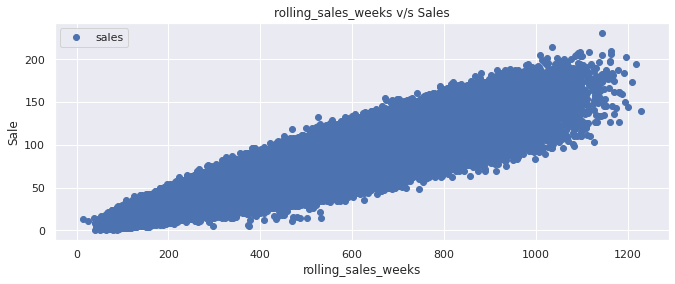

In [ ]:
df.plot(x='rolling_sales_weeks', y='sales', style='o')
plt.title('rolling_sales_weeks v/s Sales')
plt.xlabel('rolling_sales_weeks')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['rolling_sales_weeks', 'sales']].corr()

,rolling_sales_weeks,sales
rolling_sales_weeks,1.0000,0.9363
sales,0.9363,1.0000


**Rolling_sales_months v/s Sales**

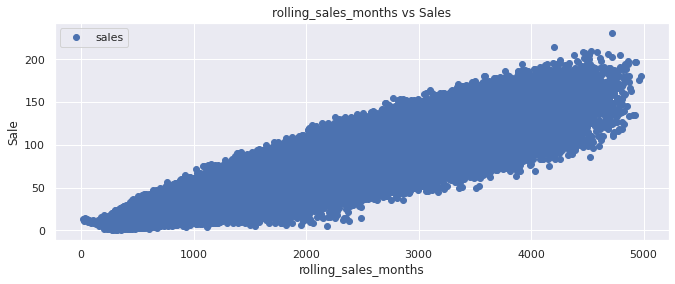

In [ ]:
df.plot(x='rolling_sales_months', y='sales', style='o')
plt.title('rolling_sales_months vs Sales')
plt.xlabel('rolling_sales_months')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['rolling_sales_months', 'sales']].corr()

,rolling_sales_months,sales
rolling_sales_months,1.000000,0.924884
sales,0.924884,1.000000


**Rolling_sales_three_months v/s Sales**

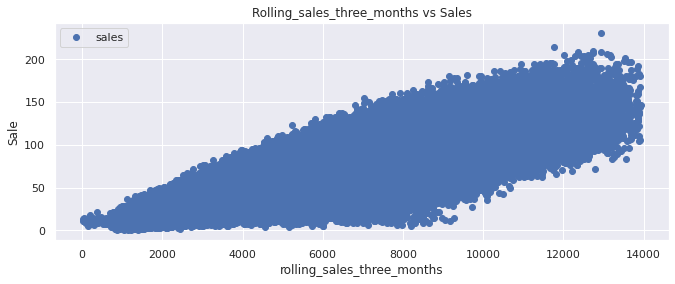

In [ ]:
df.plot(x='rolling_sales_three_months', y='sales', style='o')
plt.title('Rolling_sales_three_months vs Sales')
plt.xlabel('rolling_sales_three_months')
plt.ylabel('Sale')
plt.show()

In [ ]:
df[['rolling_sales_three_months', 'sales']].corr()

,rolling_sales_three_months,sales
rolling_sales_three_months,1.000000,0.883542
sales,0.883542,1.000000


In [ ]:
b = []
for i in df.keys():
  b.append(i)
print(b) 

['date', 'week_days', 'year', 'month', 'store', 'item', 'rolling_sales_weeks', 'rolling_sales_months', 'rolling_sales_three_months', 'sales']


In [ ]:
df["week_days"].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [ ]:
df_main = df.copy()

###**Encoding**

In [ ]:
a ={"Monday" : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday': 6}
e = {7:1, 6: 3, 5:4, 1:7, 4:11, 9:12, 10:15, 3:16, 8:19, 2:21}
c = {1:1, 12:3, 2:4, 3:8, 10:10, 9:12, 4:13, 11:14, 8:17, 5:18, 6:21, 7:24}
d = {5:1, 1:4, 41:5, 47:6, 4:7, 27:8, 16:11, 34:12, 40:16, 37:17, 23: 18, 49:19 \
     , 44:20, 17:23, 3:26, 42:27, 21:30, 30:31, 19:32, 39:35, 32:36, 20:39, 26:40, 43:43, 48:44, 9:45, 6:49\
     , 7:50, 2:51, 46:52, 31:53, 14:54, 35:59, 50:60, 24:61, 33:63, 29:64, 12:65, 11:66, 10:68, 8:70, 36:71, 22:73, 38:74\
     , 45:75, 25:76, 18:78, 13:79, 28:82, 15:83}
df['week_days'] = df['week_days'].map(a)
df['store'] = df['store'].map(e)
df['month'] = df['month'].map(c)
df['item'] = df['item'].map(d)
df['year'] = (df['year']-2013)+1


# df = pd.get_dummies(df, columns = ['week_days'])

In [ ]:
df

,date,week_days,year,month,store,item,rolling_sales_weeks,rolling_sales_months,rolling_sales_three_months,sales
0,2013-01-01,1,1,1,7,4,13,13,13,13
1,2013-01-02,2,1,1,7,4,24,24,24,11
2,2013-01-03,3,1,1,7,4,38,38,38,14
3,2013-01-04,4,1,1,7,4,51,51,51,13
4,2013-01-05,5,1,1,7,4,61,61,61,10
...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,2,5,3,15,60,439,1927,6984,63
912996,2017-12-28,3,5,3,15,60,435,1918,6953,59
912997,2017-12-29,4,5,3,15,60,434,1916,6924,74
912998,2017-12-30,5,5,3,15,60,426,1905,6887,62


##**CHECK THE MODEL IN TWO WAYS**
*********************************
*********************************


###1.   **MODEL WITH ROLLING SUMS**

THIS IS USED FOR ANALYSING DATA WITH OUR NEW FEATURES. HOW SALES  DEPENDING IN THE FEATURES. THESE ROLLING SUMS ARE DERIVED FROM OUR TARGET SALES. SO, WE CAN'T USE THIS MODEL FOR FORECASTING.
###2.   **MODEL WITHOUT ROLLING SUMS**

SO WE ARE GOING TO FORECASTING DATA FOR NEXT YEAR(2018) BY THE 2ND MODEL.



###**SPLITTING OF DATA**
*****
Here we need to identify the 3 month sale. So here I set the last three months(2017-10-01 to 2017-12-31) for testing. The rest of the data is reserved for training. So, random split not make any sence here.

In [ ]:
split_date = '2017-09-30'
train = df.loc[df['date'] <= split_date]
test = df.loc[df['date'] > split_date]

In [ ]:
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (867000, 10)
Test Dataset: (46000, 10)


In [ ]:
b = []
for i in train.keys():
  b.append(i)
print(b) 

['date', 'week_days', 'year', 'month', 'store', 'item', 'rolling_sales_weeks', 'rolling_sales_months', 'rolling_sales_three_months', 'sales']


In [ ]:
# We want to remove target varible 'sales' and unnecessary column date.
b.remove('sales')
b.remove('date')
print(b)

['week_days', 'year', 'month', 'store', 'item', 'rolling_sales_weeks', 'rolling_sales_months', 'rolling_sales_three_months']


In [ ]:
# forecast_dataforecast_data We are going to define the variable and the target sets for both the test and train datas.
X_train = train[b].values
X_test = test[b].values
y_train = train['sales'].values
y_test = test['sales'].values

In [ ]:
from sklearn.preprocessing import StandardScaler ## standrard scalig 
scaler = StandardScaler() #initialise to a variable
scaler.fit(X_train,y_train) # we are finding the values of mean and sd from the td
X_train = scaler.transform(X_train) # fit (mean, sd) and then transform the training data
X_test = scaler.transform(X_test) # transform the test dat

##**MODEL TRAINING**

###**(1) LINEAR REGRESSION**
****
*****

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_,[b], columns=['Coefficient'])
y_pred = regressor.predict(X_test)
coeff_df

,Coefficient
week_days,6.413939
year,0.353603
month,0.610158
store,0.649910
item,1.345845
rolling_sales_weeks,27.319982
rolling_sales_months,-0.945716
rolling_sales_three_months,-1.038474


In [ ]:
print(y_pred)

[32.12691201 12.60347025 15.82087285 ... 64.97710608 67.05921085
 71.11215139]


In [ ]:
regressor.intercept_ # c 

52.12150519031142

In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9173768609411951


####**Here we have 91.7% accuracy of R-2 score**

####**Feature Selection**
* It will show the most important feature with ranking.

In [ ]:
from sklearn.feature_selection import RFE
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
sorted(list(zip(selector.ranking_,b)))

[(1, 'rolling_sales_three_months'),
 (1, 'rolling_sales_weeks'),
 (1, 'week_days'),
 (2, 'item'),
 (3, 'store'),
 (4, 'rolling_sales_months'),
 (5, 'month'),
 (6, 'year')]

In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)


,Actual,Predicted,date
date,,,
2017-10-01,33845,35120,2017-10-01
2017-10-02,22913,25253,2017-10-02
2017-10-03,26854,26626,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

15854

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")




we have 0.6263875329363131 % of items will not sale by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]


In [ ]:
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

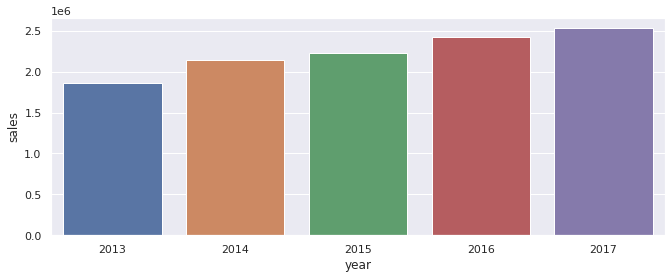

In [ ]:
m = k.groupby(k['date'].dt.year)['sales'].sum()
m = pd.DataFrame(m)
date_m = m.index.values.tolist()
m['year'] = date_m
m = m[['year', 'sales']]
sns.barplot(data=m, x="year", y="sales")

###**(2) k-NN model**
****
*****

In [ ]:
# for i in [1,2,3,4,5,6,7,8,9,10,20,50]:
#   knn = KNeighborsRegressor(i) #initialising the model
#   knn.fit(X_train,y_train) # training the model
#   print("K value  : " , i, " score : ", np.mean(cross_val_score(knn, X_train, y_train, cv=10))) 

if we run above code it will take 15 minutes it gives,

K value  :  1  score :  0.8467039423167166

K value  :  2  score :  0.8835409784943357

K value  :  3  score :  0.8954165459572071

K value  :  4  score :  0.9011986224626478

K value  :  5  score :  0.9051869106746157

K value  :  6  score :  0.9078720931476724

K value  :  7  score :  0.9097245642478677

K value  :  8  score :  0.9109886340129787

K value  :  9  score :  0.9120330952283551

K value  :  10  score :  0.9128388327374788

K value  :  20  score :  0.9161668588691606

K value  :  50  score :  0.9171968248983641

In [ ]:
knn = KNeighborsRegressor(10) 
knn.fit(X_train,y_train) # training the model

KNeighborsRegressor(n_neighbors=10)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(y_pred)

[26.4 17.5 20.4 ... 63.  68.9 68.3]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,26
1735,2017-10-02,12,18
1736,2017-10-03,18,20


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9248631626655872


####**Here we have 92% accuracy of R-2 score**

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,36182,2017-10-01
2017-10-02,22913,24170,2017-10-02
2017-10-03,26854,27877,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

24052

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 0.9472203854807324 % of items will not sale by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
#combine all test data with predicted for plotting to find out patterns
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

###**(3) Decesian Tree**
****
*****

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import  r2_score
# import numpy as np
# for depth in [1,2,3,4,5,6,7,8,9,10,20,40,60]:
#   dt = DecisionTreeRegressor(max_depth=depth) # will tell the DT to not grow past the given threhsold
#   # Fit dt to the training set
#   dt.fit(X_train, y_train) # the model is trained
#   trainAccuracy = r2_score(y_train, dt.predict(X_train)) # this is useless information - i am showing to prove a point
#   dt = DecisionTreeRegressor(max_depth=depth) # a fresh model which is not trained yet
#   valAccuracy = cross_val_score(dt, X_train, y_train, cv=10, scoring = make_scorer(r2_score)) # syntax : cross_val_Score(freshModel,fts, target, cv= 10/5)
#   print(depth, trainAccuracy, np.mean(valAccuracy))

The above code will gives following value accuracy,

1 0.6026544896875241 0.4977245544385477

2 0.7986972142624446 0.7527736397042533

3 0.8577086190740686 0.8271201874184426

4 0.903750631222365 0.883390910372535

5 0.9227341825297447 0.9064681312190824

6 0.9336571058318379 0.9194901668607228

7 0.9382453235741935 0.925015349335714

8 0.9410438435770467 0.9283314073535397

9 0.9421744303098188 0.9294505529316576

10 0.9430312378155078 0.9298989547350436

20 0.9666800015578276 0.8958606494260088

40 0.9998063406875495 0.853036627870081

60 0.9999999937476275 0.8530657454515242

SO, HERE WE WILL CHOOSE MAX DEPTH AS 10.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth= 10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [ ]:
print(y_pred)

[26.91391509 17.98292108 20.87737568 ... 66.04334738 68.40297872
 71.25900901]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred

,date,Actual,Predicted
1734,2017-10-01,21,27
1735,2017-10-02,12,18
1736,2017-10-03,18,21
1737,2017-10-04,15,19
1738,2017-10-05,20,21
...,...,...,...
912995,2017-12-27,63,56
912996,2017-12-28,59,60
912997,2017-12-29,74,66
912998,2017-12-30,62,68


In [ ]:
sum(y_pred)

2525665.6993713635

In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9315258588448584


####**Here we have 93% accuracy of R-2 score**

####**Feature Selection**
* It will show the most important feature with ranking.

In [ ]:
# from sklearn.feature_selection import RFE
from matplotlib import pyplot
importance = dt.feature_importances_
#pyplot.bar([x for x in range(len(importance))], importance)
list(zip(importance,b))

[(0.06777449157441205, 'week_days'),
 (6.139321467856827e-05, 'year'),
 (0.0005400220514684071, 'month'),
 (1.1204775804144586e-05, 'store'),
 (4.129171241393854e-05, 'item'),
 (0.9311141915391004, 'rolling_sales_weeks'),
 (0.00014267941801261846, 'rolling_sales_months'),
 (0.0003147257141098071, 'rolling_sales_three_months')]

<BarContainer object of 8 artists>

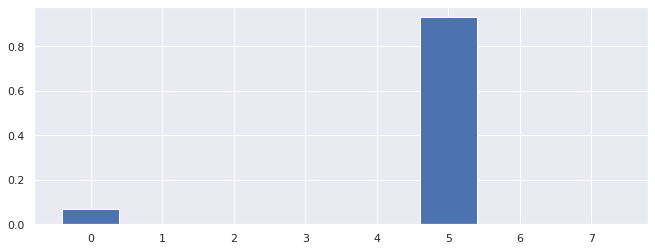

In [ ]:
pyplot.bar([x for x in range(len(importance))], importance)

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)


,Actual,Predicted,date
date,,,
2017-10-01,33845,36406,2017-10-01
2017-10-02,22913,23960,2017-10-02
2017-10-03,26854,27813,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

10241

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 0.4055186330288017 % of items will not sale by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
#Combine the test and train datas.
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

###**(4) Random Forest**
****
*****

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(n_estimators= 100, max_depth = 10, max_features='sqrt')
rf.fit(X_train, y_train);
y_pred = rf.predict(X_test)
r2_score(y_pred, y_test)

0.919410397604762

In [ ]:
print(y_pred)

[25.81064563 19.86253755 21.53469074 ... 66.06629196 66.93852861
 68.76810697]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,26
1735,2017-10-02,12,20
1736,2017-10-03,18,22


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9284228771853995



####**Here we have 92.8% accuracy of R-2 score**

####**Feature Selection**
* It will show the most important feature with ranking.

In [ ]:
from sklearn import tree

In [ ]:
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = b, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png');

The output image has lots of branches in the tree. So I am going to show the sample tree image with max depth for 3.

In [ ]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = b, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

**THE OUTPUT IMAGE OF THIS CODE IS,**
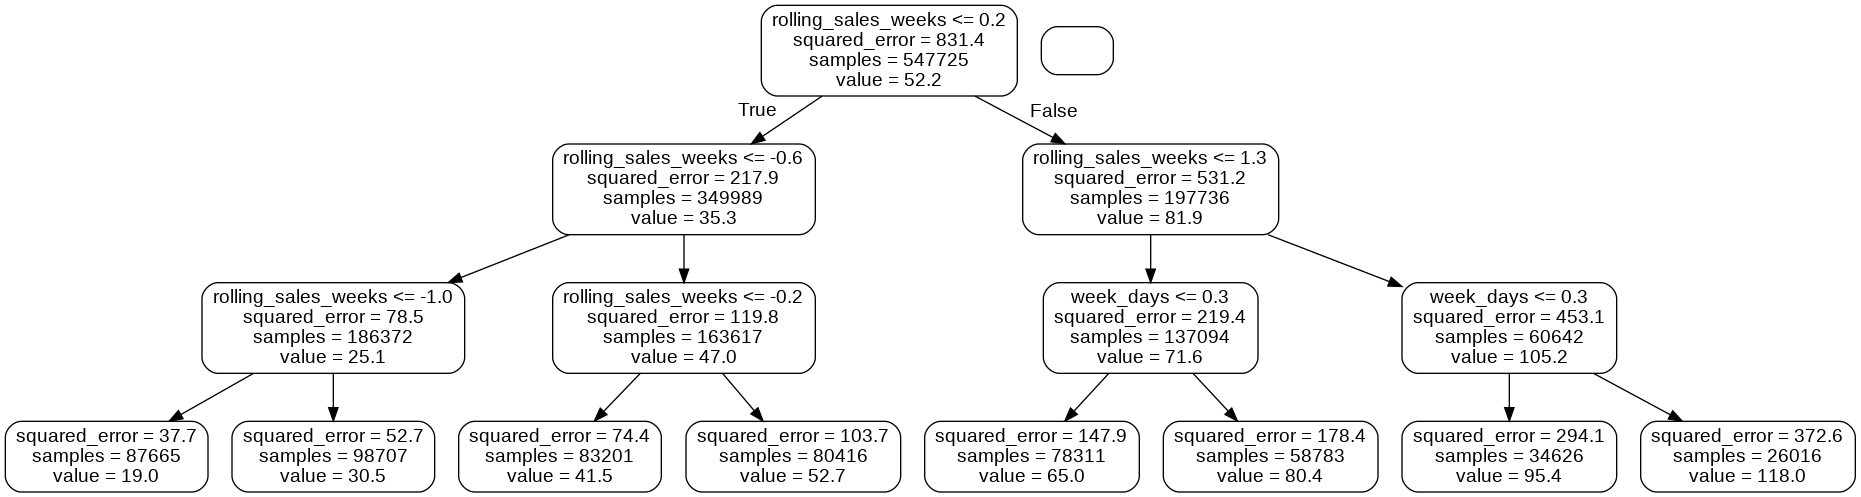

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(b, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: rolling_sales_weeks  Importance: 0.35
Variable: rolling_sales_months Importance: 0.28
Variable: rolling_sales_three_months Importance: 0.18
Variable: item                 Importance: 0.09
Variable: week_days            Importance: 0.05
Variable: month                Importance: 0.02
Variable: store                Importance: 0.02
Variable: year                 Importance: 0.0


In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,34646,2017-10-01
2017-10-02,22913,25794,2017-10-02
2017-10-03,26854,28161,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

7977

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 0.3161531803178891 % of items will not sale by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
#Adding predicted data with test for plotting
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

###**(5) XG Boost**
****
*****

In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# import numpy as np
# for lr in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
#   model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
#   model.fit(X_train,y_train) #train the model
#    # scoring the model - r2 squared
#   print("Learning rate : ", lr, " score : ", model.score(X_test, y_test))

The above code gives the following,..

Learning rate :  0.01  score :  0.3111435207650425

Learning rate :  0.02  score :  0.8473083375249416

Learning rate :  0.03  score :  0.9198474677371754

Learning rate :  0.04  score :  0.9294022385273867

Learning rate :  0.05  score :  0.9314447745255183

Learning rate :  0.06  score :  0.9321544768686629

Learning rate :  0.07  score :  0.9325668800329064

Learning rate :  0.08  score :  0.9323772572698595

Learning rate :  0.09  score :  0.9326075877390344

Learning rate :  0.1  score :  0.9327693789441619

Learning rate :  0.11  score :  0.9325654761420428

Learning rate :  0.12  score :  0.9331112587143044

Learning rate :  0.13  score :  0.933164938326622

Learning rate :  0.14  score :  0.9333619620533834

Learning rate :  0.15  score :  0.9341763584077387

Learning rate :  0.2  score :  0.9341081836190079

Learning rate :  0.5  score :  0.9361336287408715

Learning rate :  0.7  score :  0.9359851132051905

Learning rate :  1  score :  0.9364791588542069

We will choose the value 0.5 here.

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(learning_rate = 0.5, n_estimators=100)
model.fit(X_train,y_train) #train the model
model.score(X_test, y_test)

[16:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9349541445822255

In [ ]:
y_pred= model.predict(X_test)

In [ ]:
print(y_pred)

[26.229511 17.460478 20.85693  ... 62.963093 66.72266  71.20808 ]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,26
1735,2017-10-02,12,17
1736,2017-10-03,18,21


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9349541445822255


####**Here we have 93.4% accuracy of R-2 score**

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,36065,2017-10-01
2017-10-02,22913,23696,2017-10-02
2017-10-03,26854,27478,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

-12314

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 0.49199853127610776 % of opportunity lost will happen by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

###**REMARKS FROM ABOVE MODELS (WITH ROLLING SUMS)**
********************************
********************************

THROUGH ROLLING SUM IT SHOWS VARIOUS PATTERNS. WE OBTAIN THESE FEATURES FROM OUR TARGET SALE. IN THE ACTUAL SITUATION THIS IS NOT POSSIBLE. SO WE NEED TO TRAIN OUR MODEL FROM OTHER FEATURES.

##**Forecast the demand for 3 months from 2018-01-01 to 2018-03-31(NEW!)**
*****
*****
1.   **Create dataset without rolling sales(we can't able to found out these features)**
2.   **FOR THIS NEED TO CREATE ENTIRE DATA SET from 2018-01-01 to 2018-03-31 WITH FEATURES.**

**REFERENCE FOR CREATING NEW DATA SET**
*************


*   Create data frame with one column as date in particular range [stack overflow](https://stackoverflow.com/questions/71817874/create-a-data-frame-that-includes-all-dates-between-a-range-for-each-sku)
*  Create data frame for multi row concept [(stack overflow)](https://stackoverflow.com/questions/71817874/create-a-data-frame-that-includes-all-dates-between-a-range-for-each-sku) with 50 items in 10 stores with same date.




###**CREATE MODEL ONLY WITH 5 FEATURES(FORECASTING FOR NEXT YEAR 2018)**

In [ ]:
forecast_data = pd.MultiIndex.from_product([
    pd.date_range(start='2018-01-01', end='2018-03-31', freq='D'),
    [i+1 for i in range(10)],
    [i+1 for i in range(50)]], names=['date', 'store', 'item']).to_frame(index=False)
forecast_data['week_days'] = forecast_data['date'].dt.day_name()
forecast_data['year'] = forecast_data['date'].dt.year
forecast_data['month'] = forecast_data['date'].dt.month
forecast_datan = forecast_data.copy()
a ={"Monday" : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday': 6}
e = {7:1, 6: 3, 5:4, 1:7, 4:11, 9:12, 10:15, 3:16, 8:19, 2:21}
c = {1:1, 12:3, 2:4, 3:8, 10:10, 9:12, 4:13, 11:14, 8:17, 5:18, 6:21, 7:24}
d = {5:1, 1:4, 41:5, 47:6, 4:7, 27:8, 16:11, 34:12, 40:16, 37:17, 23: 18, 49:19 \
     , 44:20, 17:23, 3:26, 42:27, 21:30, 30:31, 19:32, 39:35, 32:36, 20:39, 26:40, 43:43, 48:44, 9:45, 6:49\
     , 7:50, 2:51, 46:52, 31:53, 14:54, 35:59, 50:60, 24:61, 33:63, 29:64, 12:65, 11:66, 10:68, 8:70, 36:71, 22:73, 38:74\
     , 45:75, 25:76, 18:78, 13:79, 28:82, 15:83}
forecast_data['week_days'] = forecast_data['week_days'].map(a)
forecast_data['store'] = forecast_data['store'].map(e)
forecast_data['month'] = forecast_data['month'].map(c)
forecast_data['item'] = forecast_data['item'].map(d)
forecast_data['year'] = (forecast_data['year']-2013)+1
forecast_data = forecast_data[['date', 'week_days', 'year', 'month', 'store', 'item']]


In [ ]:
forecast_data1 = forecast_data.copy()

In [ ]:
forecast_data1.drop(forecast_data.columns[[0]], axis=1, inplace=True)
forecast_data1

,week_days,year,month,store,item
0,0,6,1,7,4
1,0,6,1,7,51
2,0,6,1,7,26
3,0,6,1,7,7
4,0,6,1,7,1
...,...,...,...,...,...
44995,5,6,8,15,52
44996,5,6,8,15,6
44997,5,6,8,15,44
44998,5,6,8,15,19


In [ ]:
forecast_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   week_days  45000 non-null  int64
 1   year       45000 non-null  int64
 2   month      45000 non-null  int64
 3   store      45000 non-null  int64
 4   item       45000 non-null  int64
dtypes: int64(5)
memory usage: 1.7 MB


In [ ]:
Forecast_data_val = forecast_data1.values

In [ ]:
# from sklearn.preprocessing import StandardScaler ## standrard scalig 
# scaler = StandardScaler() #initialise to a variable
# scaler.fit(X_train,y_train) # we are finding the values of mean and sd from the td
# X_train = scaler.transform(X_train) # fit (mean, sd) and then transform the training data
Forecast_data_val = scaler.transform(Forecast_data_val) # transform the test dat

###**TRAIN THE MODEL USING GIVEN DATASET WITH ABOVE FIVE FEATURES**
******************
THE REAL FEATURES WE CONSTRUCTED,

In [ ]:
b

['week_days',
 'year',
 'month',
 'store',
 'item',
 'rolling_sales_weeks',
 'rolling_sales_months',
 'rolling_sales_three_months']

Clearly from the above features,

1.  rolling_sales_weeks',
2.  'rolling_sales_months',
3. 'rolling_sales_three_months'
which are iterated from the sale column.
******
NOW OUR TASK IS TO CREATE THE MODEL WITHOUT THESE THREE FEATURES.
 

In [ ]:
# We want to remove 3 FEATURES FROM THE SET.
b.remove('rolling_sales_weeks')
b.remove('rolling_sales_months')
b.remove('rolling_sales_three_months')
print(b)

['week_days', 'year', 'month', 'store', 'item']


In [ ]:
# forecast_dataforecast_data We are going to define the variable and the target sets for both the test and train datas.
X_train = train[b].values
X_test = test[b].values
y_train = train['sales'].values
y_test = test['sales'].values

In [ ]:
from sklearn.preprocessing import StandardScaler ## standrard scalig 
scaler = StandardScaler() #initialise to a variable
scaler.fit(X_train,y_train) # we are finding the values of mean and sd from the td
X_train = scaler.transform(X_train) # fit (mean, sd) and then transform the training data
X_test = scaler.transform(X_test) # transform the test dat

###**(1) APPLY LINEAR REGRESSION**
****
*****

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_,[b], columns=['Coefficient'])
y_pred = regressor.predict(X_test)
coeff_df

,Coefficient
week_days,6.387831
year,5.149460
month,9.438346
store,10.197625
item,21.198325


In [ ]:
print(y_pred)

[26.49810401  7.32078279 10.51700299 ... 71.37043519 74.56665539
 77.7628756 ]


In [ ]:
regressor.intercept_ # c 

52.12150519031142

In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,26
1735,2017-10-02,12,7
1736,2017-10-03,18,11


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.867213731434604


####**Here we have 86% accuracy of R-2 score**

####**Feature Selection**
* It will show the most important feature with ranking.

In [ ]:
from sklearn.feature_selection import RFE
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
sorted(list(zip(selector.ranking_,b)))

[(1, 'item'), (1, 'month'), (1, 'store'), (2, 'week_days'), (3, 'year')]

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,33272,2017-10-01
2017-10-02,22913,23680,2017-10-02
2017-10-03,26854,25281,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

44104

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 1.7233032375234978 % of items will not sale by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

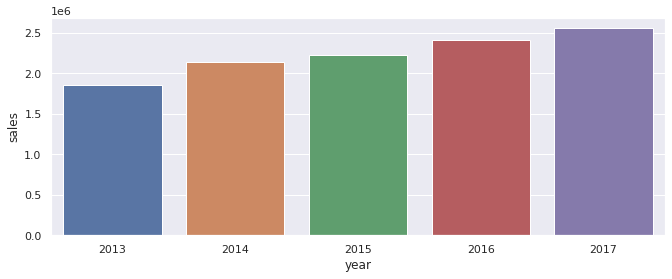

In [ ]:
m = k.groupby(k['date'].dt.year)['sales'].sum()
m = pd.DataFrame(m)
date_m = m.index.values.tolist()
m['year'] = date_m
m = m[['year', 'sales']]
sns.barplot(data=m, x="year", y="sales")

####**APPLY LR MODEL TO OUR NEW DATASET**
********
********

In [ ]:
y_pred= regressor.predict(Forecast_data_val)

In [ ]:
forecast_data['Predicted'] = y_pred.astype(int)

In [ ]:
forecast_data

,date,week_days,year,month,store,item,Predicted
0,2018-01-01,0,6,1,7,4,-1
1,2018-01-01,0,6,1,7,51,39
2,2018-01-01,0,6,1,7,26,17
3,2018-01-01,0,6,1,7,7,1
4,2018-01-01,0,6,1,7,1,-3
...,...,...,...,...,...,...,...
44995,2018-03-31,5,6,8,15,52,78
44996,2018-03-31,5,6,8,15,6,38
44997,2018-03-31,5,6,8,15,44,71
44998,2018-03-31,5,6,8,15,19,49


In [ ]:

Predicted_pred = forecast_data.groupby(forecast_data["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Predicted': Predicted_pred})
df_pred1
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1

,Predicted,date
date,,
2018-01-01,19275,2018-01-01
2018-01-02,20870,2018-01-02
2018-01-03,22453,2018-01-03
2018-01-04,24047,2018-01-04
2018-01-05,25642,2018-01-05
...,...,...
2018-03-27,25560,2018-03-27
2018-03-28,27153,2018-03-28
2018-03-29,28759,2018-03-29


In [ ]:
fig = px.line(df_pred1, x='date', y=["Predicted"])
fig.show()

In [ ]:
forecast_datan['Predicted'] = y_pred.astype(int)
forecast_datan

,date,store,item,week_days,year,month,Predicted
0,2018-01-01,1,1,Monday,2018,1,-1
1,2018-01-01,1,2,Monday,2018,1,39
2,2018-01-01,1,3,Monday,2018,1,17
3,2018-01-01,1,4,Monday,2018,1,1
4,2018-01-01,1,5,Monday,2018,1,-3
...,...,...,...,...,...,...,...
44995,2018-03-31,10,46,Saturday,2018,3,78
44996,2018-03-31,10,47,Saturday,2018,3,38
44997,2018-03-31,10,48,Saturday,2018,3,71
44998,2018-03-31,10,49,Saturday,2018,3,49


In [ ]:
ITEMS = forecast_datan['item'].unique().tolist()
for i in ITEMS:
  print("For the item", i)
  print('%%%%%%%%%%%%%%%%%%%')
  print(forecast_datan[forecast_datan['item']== i].groupby('month').Predicted.sum())
  print('------------------------------------------------')

For the item 1
%%%%%%%%%%%%%%%%%%%
month
1    4210
2    5076
3    7384
Name: Predicted, dtype: int64
------------------------------------------------
For the item 2
%%%%%%%%%%%%%%%%%%%
month
1    16756
2    16428
3    19950
Name: Predicted, dtype: int64
------------------------------------------------
For the item 3
%%%%%%%%%%%%%%%%%%%
month
1    10051
2    10376
3    13265
Name: Predicted, dtype: int64
------------------------------------------------
For the item 4
%%%%%%%%%%%%%%%%%%%
month
1    5006
2    5804
3    8174
Name: Predicted, dtype: int64
------------------------------------------------
For the item 5
%%%%%%%%%%%%%%%%%%%
month
1    3437
2    4372
3    6584
Name: Predicted, dtype: int64
------------------------------------------------
For the item 6
%%%%%%%%%%%%%%%%%%%
month
1    16197
2    15940
3    19412
Name: Predicted, dtype: int64
------------------------------------------------
For the item 7
%%%%%%%%%%%%%%%%%%%
month
1    16478
2    16192
3    19680
Name: Predicted, 

###**(2) k-NN model**
****
*****

In [ ]:
# for i in [1,2,3,4,5,6,7,8,9,10,20,50]:
#   knn = KNeighborsRegressor(i) #initialising the model
#   knn.fit(X_train,y_train) # training the model
#   print("K value  : " , i, " score : ", np.mean(cross_val_score(knn, X_train, y_train, cv=10))) 

if we run above code it will take 15 minutes it gives,

K value  :  1  score :  0.845796028759778

K value  :  2  score :  0.8840147977445124

K value  :  3  score :  0.8967835239865826

K value  :  4  score :  0.9031569383718363

K value  :  5  score :  0.9072074551804844

K value  :  6  score :  0.9097794698724471

K value  :  7  score :  0.9113577123736751

K value  :  8  score :  0.9124454264377408

K value  :  9  score :  0.9135649973416109

K value  :  10  score :  0.914350431239555

K value  :  20  score :  0.9178249029809846

K value  :  50  score :  0.9188835059956725

In [ ]:
knn = KNeighborsRegressor() 
knn.fit(X_train,y_train) # training the model

KNeighborsRegressor()

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(y_pred)

[22.4 16.4 17.  ... 65.4 70.6 74.2]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,22
1735,2017-10-02,12,16
1736,2017-10-03,18,17


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9115504627547245


####**Here we have 91% accuracy of R-2 score**

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,32670,2017-10-01
2017-10-02,22913,21750,2017-10-02
2017-10-03,26854,25391,2017-10-03


In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 2.201431131373959 % of opportunity lost will happen by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
#combine all test data with predicted for plotting to find out patterns
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

####**APPLY KNN MODEL TO OUR NEW DATASET**
********
********

In [ ]:
y_pred= knn.predict(Forecast_data_val)

In [ ]:
forecast_data['Predicted'] = y_pred.astype(int)

In [ ]:
forecast_data.head(3)

,date,week_days,year,month,store,item,Predicted
0,2018-01-01,0,6,1,7,4,13
1,2018-01-01,0,6,1,7,51,26
2,2018-01-01,0,6,1,7,26,21


In [ ]:
Predicted_pred = forecast_data.groupby(forecast_data["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Predicted': Predicted_pred})
df_pred1
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Predicted,date
date,,
2018-01-01,15558,2018-01-01
2018-01-02,18360,2018-01-02
2018-01-03,18318,2018-01-03


In [ ]:
fig = px.line(df_pred1, x='date', y=["Predicted"])
fig.show()

In [ ]:
forecast_datan['Predicted'] = y_pred.astype(int)
forecast_datan

,date,store,item,week_days,year,month,Predicted
0,2018-01-01,1,1,Monday,2018,1,13
1,2018-01-01,1,2,Monday,2018,1,26
2,2018-01-01,1,3,Monday,2018,1,21
3,2018-01-01,1,4,Monday,2018,1,13
4,2018-01-01,1,5,Monday,2018,1,10
...,...,...,...,...,...,...,...
44995,2018-03-31,10,46,Saturday,2018,3,71
44996,2018-03-31,10,47,Saturday,2018,3,28
44997,2018-03-31,10,48,Saturday,2018,3,58
44998,2018-03-31,10,49,Saturday,2018,3,40


In [ ]:
ITEMS = forecast_datan['item'].unique().tolist()
for i in ITEMS:
  print("For the item", i)
  print('%%%%%%%%%%%%%%%%%%%')
  print(forecast_datan[forecast_datan['item']== i].groupby('month').Predicted.sum())
  print('------------------------------------------------')

For the item 1
%%%%%%%%%%%%%%%%%%%
month
1    5011
2    5220
3    6655
Name: Predicted, dtype: int64
------------------------------------------------
For the item 2
%%%%%%%%%%%%%%%%%%%
month
1    13218
2    13980
3    18184
Name: Predicted, dtype: int64
------------------------------------------------
For the item 3
%%%%%%%%%%%%%%%%%%%
month
1     8450
2     8628
3    11520
Name: Predicted, dtype: int64
------------------------------------------------
For the item 4
%%%%%%%%%%%%%%%%%%%
month
1    4968
2    5036
3    6804
Name: Predicted, dtype: int64
------------------------------------------------
For the item 5
%%%%%%%%%%%%%%%%%%%
month
1    4415
2    4448
3    5782
Name: Predicted, dtype: int64
------------------------------------------------
For the item 6
%%%%%%%%%%%%%%%%%%%
month
1    13695
2    13744
3    18251
Name: Predicted, dtype: int64
------------------------------------------------
For the item 7
%%%%%%%%%%%%%%%%%%%
month
1    13494
2    13800
3    18305
Name: Predicted, 

###**(3) Decesian Tree**
****
*****

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import  r2_score
# import numpy as np
# for depth in [1,2,3,4,5,6,7,8,9,10,20,40,60]:
#   dt = DecisionTreeRegressor(max_depth=depth) # will tell the DT to not grow past the given threhsold
#   # Fit dt to the training set
#   dt.fit(X_train, y_train) # the model is trained
#   trainAccuracy = r2_score(y_train, dt.predict(X_train)) # this is useless information - i am showing to prove a point
#   dt = DecisionTreeRegressor(max_depth=depth) # a fresh model which is not trained yet
#   valAccuracy = cross_val_score(dt, X_train, y_train, cv=10, scoring = make_scorer(r2_score)) # syntax : cross_val_Score(freshModel,fts, target, cv= 10/5)
#   print(depth, trainAccuracy, np.mean(valAccuracy))

The above code will gives following value accuracy,

1 0.42025924173504803 0.2724527886330169

2 0.5689066838236991 0.46502607447848304

3 0.6742373029395914 0.588683380674986

4 0.7430989778283397 0.6756374359510937

5 0.7942629547811055 0.7365583423653397

6 0.8317380610399896 0.7845643610970677

7 0.858910046884934 0.8184820225598894

8 0.8808187008067481 0.8452869889622999

9 0.8984416701544173 0.8683016193094701

10 0.911562347860588 0.884801283884926

20 0.951021938916441 0.9045683642824155

40 0.9516350382762504 0.9042471718269611

60 0.9516350382762504 0.9042471718269611

SO, HERE WE WILL CHOOSE MAX DEPTH AS 20.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth= 20)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [ ]:
print(y_pred)

[27.   19.6  20.   ... 64.   69.75 69.25]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,27
1735,2017-10-02,12,20
1736,2017-10-03,18,20


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.911663332309354


####**Here we have 91% accuracy of R-2 score**

####**Feature Selection**
* It will show the most important feature with ranking.

In [ ]:
# from sklearn.feature_selection import RFE
from matplotlib import pyplot
importance = dt.feature_importances_
#pyplot.bar([x for x in range(len(importance))], importance)
list(zip(importance,b))

[(0.06737638898113196, 'week_days'),
 (0.04596940875298721, 'year'),
 (0.14544069039308183, 'month'),
 (0.15707529373731288, 'store'),
 (0.584138218135486, 'item')]

<BarContainer object of 5 artists>

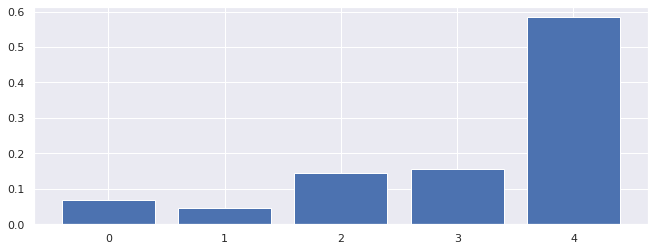

In [ ]:
pyplot.bar([x for x in range(len(importance))], importance)

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)


,Actual,Predicted,date
date,,,
2017-10-01,33845,33037,2017-10-01
2017-10-02,22913,22015,2017-10-02
2017-10-03,26854,25781,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

-45877

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 1.8579024739904995 % of opportunity lost will happen by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
#Combine the test and train datas.
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

####**APPLY DT MODEL TO OUR NEW DATASET**
********
********

In [ ]:
y_pred= dt.predict(Forecast_data_val)

In [ ]:
forecast_data['Predicted'] = y_pred.astype(int)

In [ ]:
forecast_data.head(3)

,date,week_days,year,month,store,item,Predicted
0,2018-01-01,0,6,1,7,4,13
1,2018-01-01,0,6,1,7,51,26
2,2018-01-01,0,6,1,7,26,21


In [ ]:
Predicted_pred = forecast_data.groupby(forecast_data["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Predicted': Predicted_pred})
df_pred1
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Predicted,date
date,,
2018-01-01,15559,2018-01-01
2018-01-02,18354,2018-01-02
2018-01-03,18328,2018-01-03


In [ ]:
fig = px.line(df_pred1, x='date', y=["Predicted"])
fig.show()

In [ ]:
forecast_datan['Predicted'] = y_pred.astype(int)
forecast_datan

,date,store,item,week_days,year,month,Predicted
0,2018-01-01,1,1,Monday,2018,1,13
1,2018-01-01,1,2,Monday,2018,1,26
2,2018-01-01,1,3,Monday,2018,1,21
3,2018-01-01,1,4,Monday,2018,1,13
4,2018-01-01,1,5,Monday,2018,1,10
...,...,...,...,...,...,...,...
44995,2018-03-31,10,46,Saturday,2018,3,70
44996,2018-03-31,10,47,Saturday,2018,3,29
44997,2018-03-31,10,48,Saturday,2018,3,55
44998,2018-03-31,10,49,Saturday,2018,3,37


In [ ]:
ITEMS = forecast_datan['item'].unique().tolist()
for i in ITEMS:
  print("For the item", i)
  print('%%%%%%%%%%%%%%%%%%%')
  print(forecast_datan[forecast_datan['item']== i].groupby('month').Predicted.sum())
  print('------------------------------------------------')

For the item 1
%%%%%%%%%%%%%%%%%%%
month
1    5049
2    5204
3    6656
Name: Predicted, dtype: int64
------------------------------------------------
For the item 2
%%%%%%%%%%%%%%%%%%%
month
1    13229
2    13932
3    18300
Name: Predicted, dtype: int64
------------------------------------------------
For the item 3
%%%%%%%%%%%%%%%%%%%
month
1     8449
2     8608
3    11509
Name: Predicted, dtype: int64
------------------------------------------------
For the item 4
%%%%%%%%%%%%%%%%%%%
month
1    4923
2    5040
3    6752
Name: Predicted, dtype: int64
------------------------------------------------
For the item 5
%%%%%%%%%%%%%%%%%%%
month
1    4342
2    4296
3    5690
Name: Predicted, dtype: int64
------------------------------------------------
For the item 6
%%%%%%%%%%%%%%%%%%%
month
1    13794
2    13712
3    18355
Name: Predicted, dtype: int64
------------------------------------------------
For the item 7
%%%%%%%%%%%%%%%%%%%
month
1    13526
2    13764
3    18292
Name: Predicted, 

###**(4) Random Forest**
****
*****

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(n_estimators= 100, max_depth = 20, max_features='sqrt')
rf.fit(X_train, y_train);
y_pred = rf.predict(X_test)
r2_score(y_pred, y_test)

0.9124909500612148

In [ ]:
print(y_pred)

[26.08284127 17.58571581 19.72774084 ... 67.25002778 70.07945022
 66.52702814]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred.head(3)

,date,Actual,Predicted
1734,2017-10-01,21,26
1735,2017-10-02,12,18
1736,2017-10-03,18,20


In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9205828435492343



####**Here we have 92% accuracy of R-2 score**

####**Feature Selection**
* It will show the most important feature with ranking.

In [ ]:
from sklearn import tree

In [ ]:
# from sklearn.tree import export_graphviz
# import pydot

# # Pull out one tree from the forest
# tree = rf.estimators_[5]

# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = b, rounded = True, precision = 1)

# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')

# # Write graph to a png file
# graph.write_png('tree.png');

The output image has lots of branches in the tree. So I am going to show the sample tree image with max depth for 3.

In [ ]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = b, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

**THE OUTPUT IMAGE OF THIS CODE IS,**
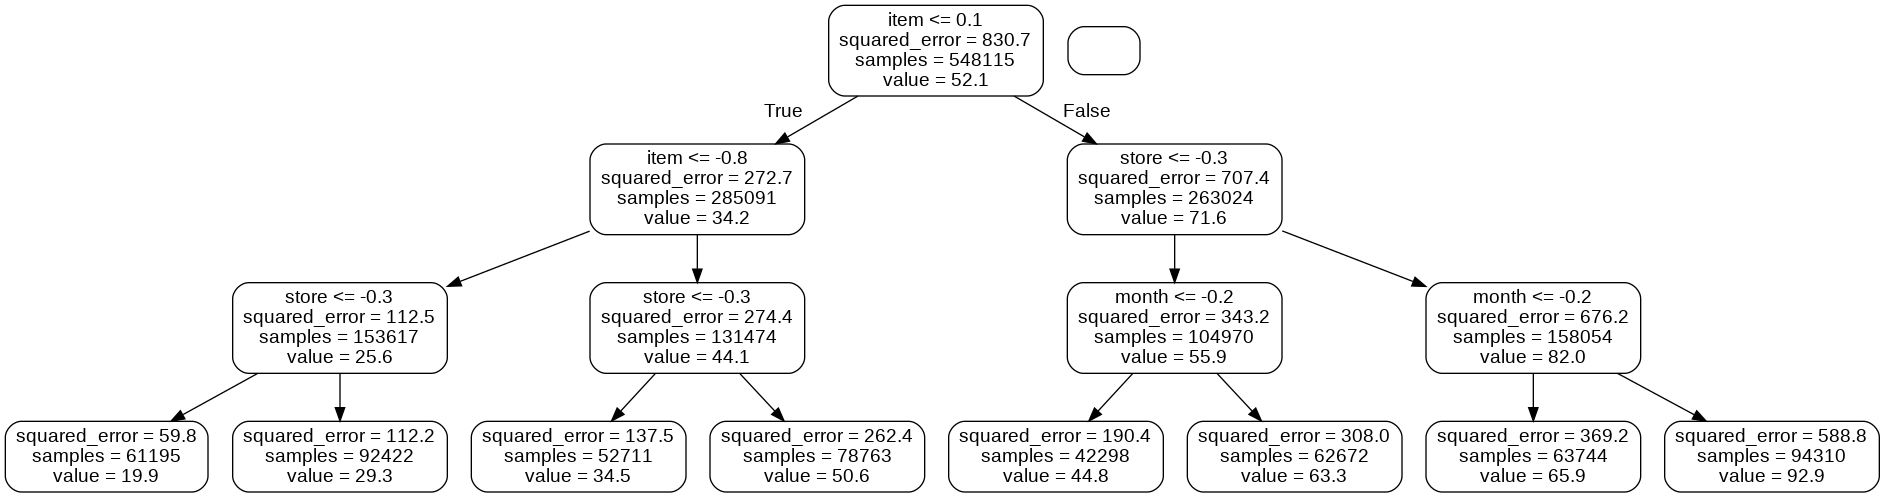

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(b, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: item                 Importance: 0.6
Variable: store                Importance: 0.15
Variable: month                Importance: 0.14
Variable: week_days            Importance: 0.06
Variable: year                 Importance: 0.05


In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,33327,2017-10-01
2017-10-02,22913,22083,2017-10-02
2017-10-03,26854,25886,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

-45971

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 1.861780109800923 % of opportunity lost will happen by this model.


In [ ]:
fig = px.bar(x=["Actual Sum","Predicted Sum"], y=[df_pred1['Actual'].sum(), df_pred1['Predicted'].sum()], color=["red", "#00D"], color_discrete_map="identity")
fig.show()

In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
#Adding predicted data with test for plotting
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(3)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-10-01,2013-10-01,19640
2013-10-02,2013-10-02,19853
2013-10-03,2013-10-03,21059


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

####**APPLY RF MODEL TO OUR NEW DATASET**
********
********

In [ ]:
y_pred= rf.predict(Forecast_data_val)

In [ ]:
forecast_data['Predicted'] = y_pred.astype(int)

In [ ]:
forecast_data.head(3)

,date,week_days,year,month,store,item,Predicted
0,2018-01-01,0,6,1,7,4,12
1,2018-01-01,0,6,1,7,51,26
2,2018-01-01,0,6,1,7,26,21


In [ ]:
Predicted_pred = forecast_data.groupby(forecast_data["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Predicted': Predicted_pred})
df_pred1
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Predicted,date
date,,
2018-01-01,15514,2018-01-01
2018-01-02,18301,2018-01-02
2018-01-03,18281,2018-01-03


In [ ]:
fig = px.line(df_pred1, x='date', y=["Predicted"])
fig.show()

In [ ]:
forecast_datan['Predicted'] = y_pred.astype(int)
forecast_datan

,date,store,item,week_days,year,month,Predicted
0,2018-01-01,1,1,Monday,2018,1,12
1,2018-01-01,1,2,Monday,2018,1,26
2,2018-01-01,1,3,Monday,2018,1,21
3,2018-01-01,1,4,Monday,2018,1,13
4,2018-01-01,1,5,Monday,2018,1,10
...,...,...,...,...,...,...,...
44995,2018-03-31,10,46,Saturday,2018,3,71
44996,2018-03-31,10,47,Saturday,2018,3,29
44997,2018-03-31,10,48,Saturday,2018,3,55
44998,2018-03-31,10,49,Saturday,2018,3,37


In [ ]:
ITEMS = forecast_datan['item'].unique().tolist()
for i in ITEMS:
  print("For the item", i)
  print('%%%%%%%%%%%%%%%%%%%')
  print(forecast_datan[forecast_datan['item']== i].groupby('month').Predicted.sum())
  print('------------------------------------------------')

For the item 1
%%%%%%%%%%%%%%%%%%%
month
1    5036
2    5156
3    6623
Name: Predicted, dtype: int64
------------------------------------------------
For the item 2
%%%%%%%%%%%%%%%%%%%
month
1    13198
2    13912
3    18277
Name: Predicted, dtype: int64
------------------------------------------------
For the item 3
%%%%%%%%%%%%%%%%%%%
month
1     8406
2     8580
3    11467
Name: Predicted, dtype: int64
------------------------------------------------
For the item 4
%%%%%%%%%%%%%%%%%%%
month
1    4912
2    4968
3    6673
Name: Predicted, dtype: int64
------------------------------------------------
For the item 5
%%%%%%%%%%%%%%%%%%%
month
1    4300
2    4256
3    5655
Name: Predicted, dtype: int64
------------------------------------------------
For the item 6
%%%%%%%%%%%%%%%%%%%
month
1    13758
2    13692
3    18322
Name: Predicted, dtype: int64
------------------------------------------------
For the item 7
%%%%%%%%%%%%%%%%%%%
month
1    13511
2    13756
3    18237
Name: Predicted, 

###**(5) BY XG Boost**
****
*****

In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# import numpy as np
# for lr in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
#   model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
#   model.fit(X_train,y_train) #train the model
#    # scoring the model - r2 squared
#   print("Learning rate : ", lr, " score : ", model.score(X_test, y_test))

**THE ABOVE CODE GIVES:**
*********
Learning rate :  0.01  score :  -0.014429908252471257

Learning rate :  0.02  score :  0.6576516458970798

Learning rate :  0.03  score :  0.8215549690739661

Learning rate :  0.04  score :  0.8729616656015636

Learning rate :  0.05  score :  0.8976607917338524

Learning rate :  0.06  score :  0.9107537073246633

Learning rate :  0.07  score :  0.9180680173759196

Learning rate :  0.08  score :  0.9221533072295569

Learning rate :  0.09  score :  0.924114229250136

Learning rate :  0.1  score :  0.9255159193276412

Learning rate :  0.11  score :  0.9269230961003273

Learning rate :  0.12  score :  0.9279078344492353

Learning rate :  0.13  score :  0.9282757899270566

Learning rate :  0.14  score :  0.9287402927046925

Learning rate :  0.15  score :  0.9287579809842452

Learning rate :  0.2  score :  0.9287021823696753

Learning rate :  0.5  score :  0.9264923599082568

Learning rate :  0.7  score :  0.9277946784574784

Learning rate :  1  score :  0.927319944374734

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(learning_rate = 0.15, n_estimators=100)
model.fit(X_train,y_train) #train the model
model.score(X_test, y_test)

[17:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9287579809842452

In [ ]:
y_pred= model.predict(X_test)

In [ ]:
print(y_pred)

[26.816414 16.994453 20.432638 ... 66.41588  71.01646  74.16546 ]


In [ ]:
df_pred = pd.DataFrame({'date': test['date'], 'Actual': y_test, 'Predicted': y_pred})
df_pred['Predicted'] = df_pred['Predicted'].round().astype(int)
df_pred

,date,Actual,Predicted
1734,2017-10-01,21,27
1735,2017-10-02,12,17
1736,2017-10-03,18,20
1737,2017-10-04,15,20
1738,2017-10-05,20,22
...,...,...,...
912995,2017-12-27,63,58
912996,2017-12-28,59,63
912997,2017-12-29,74,66
912998,2017-12-30,62,71


In [ ]:
sum(y_pred)

2510161.921292305

In [ ]:
from sklearn import metrics
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

R2- SCORE: 0.9287579809842452


####**Here we have 92.8% accuracy of R-2 score**

In [ ]:
Actual_pred = df_pred.groupby(df_pred["date"].dt.date)["Actual"].sum()
Predicted_pred = df_pred.groupby(df_pred["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Actual': Actual_pred, 'Predicted': Predicted_pred})
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Actual,Predicted,date
date,,,
2017-10-01,33845,33821,2017-10-01
2017-10-02,22913,22849,2017-10-02
2017-10-03,26854,26585,2017-10-03


In [ ]:
df_pred1['Predicted'].sum()-df_pred1['Actual'].sum()

-5002

In [ ]:
if (df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())<0:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(-100), "% of opportunity lost will happen by this model.")
else:
  print("we have",((df_pred1['Predicted'].sum()-df_pred1['Actual'].sum())/df_pred1['Predicted'].sum())*(100), "% of items will not sale by this model.")

we have 0.19926976911876312 % of opportunity lost will happen by this model.


In [ ]:
fig = px.line(df_pred1, x='date', y=["Actual","Predicted"])
fig.show()

In [ ]:
k1 = pd.DataFrame(train.groupby(['month']).get_group(10))
k1 = pd.DataFrame(train.groupby(['month']).get_group(14)).append(k1)
k1 = pd.DataFrame(train.groupby(['month']).get_group(17)).append(k1)
sales_pred = k1.groupby(k1["date"].dt.date)["sales"].sum()
df_pred2 = pd.DataFrame({'sales': sales_pred})
df_pred2
date_pred2 = df_pred2.index.values.tolist()
df_pred2['date'] = date_pred2
df_pred2 = df_pred2[['date', 'sales']]
df_pred3 = df_pred1[['date', 'Predicted']]
df_pred3 = df_pred3.rename(columns={'Predicted': 'sales'})
k = df_pred2.append(df_pred3)
k['date'] = pd.to_datetime(k['date'],format = "%Y-%m-%d")
k.head(3)

,date,sales
date,,
2013-08-01,2013-08-01,24052
2013-08-02,2013-08-02,26159
2013-08-03,2013-08-03,27866


In [ ]:
fig = px.line(k, x='date', y='sales')
fig.show()

####**APPLY XG boost MODEL TO OUR NEW DATASET**
*******

In [ ]:
y_pred= model.predict(Forecast_data_val)

In [ ]:
forecast_data['Predicted'] = y_pred.astype(int)

In [ ]:
forecast_data.head(3)

,date,week_days,year,month,store,item,Predicted
0,2018-01-01,0,6,1,7,4,10
1,2018-01-01,0,6,1,7,51,30
2,2018-01-01,0,6,1,7,26,18


In [ ]:
Predicted_pred = forecast_data.groupby(forecast_data["date"].dt.date)["Predicted"].sum()
df_pred1 = pd.DataFrame({'Predicted': Predicted_pred})
df_pred1
date_pred = df_pred1.index.values.tolist()
df_pred1['date'] = date_pred
df_pred1.head(3)

,Predicted,date
date,,
2018-01-01,15319,2018-01-01
2018-01-02,18580,2018-01-02
2018-01-03,18580,2018-01-03


In [ ]:
fig = px.line(df_pred1, x='date', y=["Predicted"])
fig.show()

In [ ]:
forecast_datan['Predicted'] = y_pred.astype(int)
forecast_datan.head(3)

,date,store,item,week_days,year,month,Predicted
0,2018-01-01,1,1,Monday,2018,1,10
1,2018-01-01,1,2,Monday,2018,1,30
2,2018-01-01,1,3,Monday,2018,1,18


In [ ]:
ITEMS = forecast_datan['item'].unique().tolist()
for i in ITEMS:
  print("For the item", i)
  print('%%%%%%%%%%%%%%%%%%%')
  print(forecast_datan[forecast_datan['item']== i].groupby('month').Predicted.sum())
  print('------------------------------------------------')

For the item 1
%%%%%%%%%%%%%%%%%%%
month
1    4893
2    5044
3    6980
Name: Predicted, dtype: int64
------------------------------------------------
For the item 2
%%%%%%%%%%%%%%%%%%%
month
1    13843
2    13792
3    18389
Name: Predicted, dtype: int64
------------------------------------------------
For the item 3
%%%%%%%%%%%%%%%%%%%
month
1     8697
2     8588
3    11507
Name: Predicted, dtype: int64
------------------------------------------------
For the item 4
%%%%%%%%%%%%%%%%%%%
month
1    4893
2    5044
3    6980
Name: Predicted, dtype: int64
------------------------------------------------
For the item 5
%%%%%%%%%%%%%%%%%%%
month
1    4093
2    4284
3    5934
Name: Predicted, dtype: int64
------------------------------------------------
For the item 6
%%%%%%%%%%%%%%%%%%%
month
1    13843
2    13792
3    18389
Name: Predicted, dtype: int64
------------------------------------------------
For the item 7
%%%%%%%%%%%%%%%%%%%
month
1    13843
2    13792
3    18389
Name: Predicted, 

##**FROM ALL THESE MODELS WE FOLLOW WITH XG BOOST FOR PRDICTION.**

**THANK YOU**